In [9]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF


class CropOptimizer:
    def __init__(self, csv_path):
        self.data_summary = pd.read_csv(csv_path)
        self.modalities = ['flair', 't1', 't1ce', 't2']
    
    def find_optimal_crop(self):
        """Finds the minimum bounding box for all slices across all modalities."""
        crop_coords = []
        for subject_id in self.data_summary['Subject ID'].unique():
            for modality in self.modalities:
                file_path = self.data_summary[
                    (self.data_summary['Subject ID'] == subject_id) &
                    (self.data_summary['Scan Type'] == modality)
                ]['File Path'].values[0]
                nii = nib.load(file_path)
                data = nii.get_fdata()
                non_zero_coords = np.argwhere(data > 0)
                crop_coords.append([
                    np.min(non_zero_coords[:, 0]), np.max(non_zero_coords[:, 0]),
                    np.min(non_zero_coords[:, 1]), np.max(non_zero_coords[:, 1])
                ])
        
        crop_coords = np.array(crop_coords)
        min_x, max_x = np.min(crop_coords[:, 0]), np.max(crop_coords[:, 1])
        min_y, max_y = np.min(crop_coords[:, 2]), np.max(crop_coords[:, 3])
        return min_x, max_x, min_y, max_y


class BrainSegmentationDataset(Dataset):
    def __init__(self, csv_path, crop_coords=None, transform=None):
        """
        Args:
            csv_path (str): Path to the CSV file with data details.
            crop_coords (tuple, optional): Coordinates for cropping (min_x, max_x, min_y, max_y).
            transform (callable, optional): Optional transforms to be applied on a sample.
        """
        self.data_summary = pd.read_csv(csv_path)
        self.subjects = self.data_summary['Subject ID'].unique()
        self.transform = transform
        self.slice_info = self._create_slice_index()
        self.crop_coords = crop_coords

    def _create_slice_index(self):
        """Create a list of (subject_id, slice_idx) pairs."""
        slice_info = []
        for subject_id in self.subjects:
            subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]
            flair_path = subject_data[subject_data['Scan Type'] == 'flair']['File Path'].values[0]
            nii = nib.load(flair_path)
            depth = nii.shape[2]  # Assume all modalities have the same depth
            slice_info.extend([(subject_id, z) for z in range(depth)])
        return slice_info

    def __len__(self):
        return len(self.slice_info)

    def __getitem__(self, idx):
        subject_id, slice_idx = self.slice_info[idx]
        subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]

        # Load input modalities
        modalities = ['flair', 't1', 't1ce', 't2']
        slices = []
        for modality in modalities:
            file_path = subject_data[subject_data['Scan Type'] == modality]['File Path'].values[0]
            nii = nib.load(file_path)
            image = nii.get_fdata().astype(np.float32)
            image = (image - np.mean(image)) / np.std(image)  # Normalize
            slice_2d = image[:, :, slice_idx]
            if self.crop_coords:
                min_x, max_x, min_y, max_y = self.crop_coords
                slice_2d = slice_2d[min_x:max_x, min_y:max_y]
            slices.append(slice_2d)

        # Stack modalities into a single tensor (C x H x W)
        images = np.stack(slices, axis=0)

        # Load segmentation mask
        seg_data = subject_data[subject_data['Scan Type'] == 'seg']
        if seg_data.empty:
            raise ValueError(f"Missing segmentation mask for subject {subject_id}")
        seg_path = seg_data['File Path'].values[0]
        seg_nii = nib.load(seg_path)
        seg_mask = seg_nii.get_fdata().astype(np.uint8)
        seg_slice = seg_mask[:, :, slice_idx]
        if self.crop_coords:
            min_x, max_x, min_y, max_y = self.crop_coords
            seg_slice = seg_slice[min_x:max_x, min_y:max_y]

        # Remap labels: 4 -> 3
        seg_slice[seg_slice == 4] = 3

        # Apply transforms if specified
        if self.transform:
            images, seg_slice = self.transform(images, seg_slice)

        return torch.tensor(images, dtype=torch.float32), torch.tensor(seg_slice, dtype=torch.long)


# Main script to optimize crop and use the dataset
csv_path = "../data/training_detailed_summary_2020.csv"
crop_optimizer = CropOptimizer(csv_path)
crop_coords = crop_optimizer.find_optimal_crop()
print(f"Optimal crop coordinates: {crop_coords}")

# Use the cropped dataset
dataset = BrainSegmentationDataset(csv_path, crop_coords=crop_coords)

# Verify dimensions
sample_image, sample_mask = dataset[0]
print(f"Sample image shape: {sample_image.shape}, Sample mask shape: {sample_mask.shape}")


Optimal crop coordinates: (40, 196, 29, 222)
Sample image shape: torch.Size([4, 156, 193]), Sample mask shape: torch.Size([156, 193])


Optimal crop coordinates: (40, 196, 29, 222)


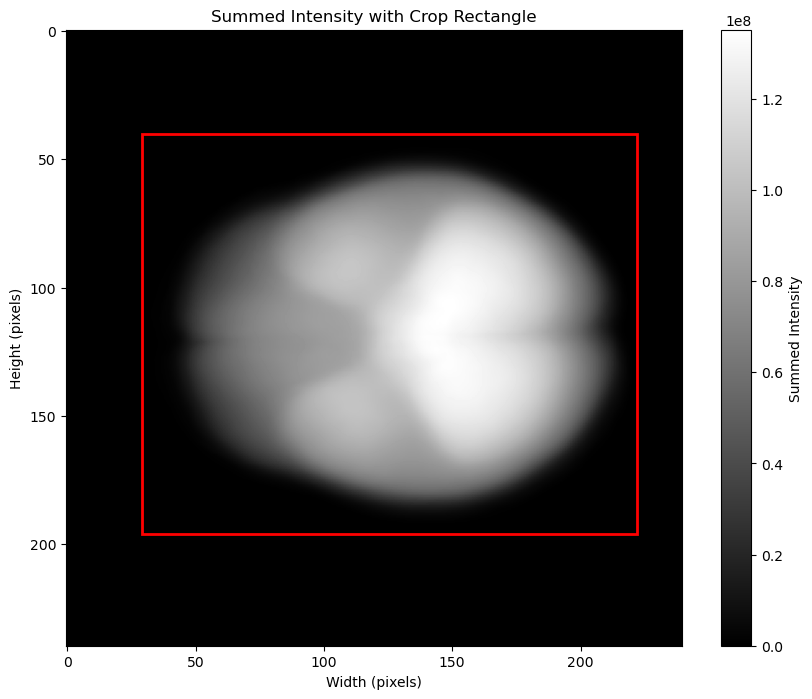

Sample image shape: torch.Size([4, 156, 193]), Sample mask shape: torch.Size([156, 193])


In [10]:
import matplotlib.pyplot as plt

class CropOptimizer:
    def __init__(self, csv_path):
        self.data_summary = pd.read_csv(csv_path)
        self.modalities = ['flair', 't1', 't1ce', 't2']
    
    def find_optimal_crop(self):
        """Finds the minimum bounding box for all slices across all modalities."""
        crop_coords = []
        for subject_id in self.data_summary['Subject ID'].unique():
            for modality in self.modalities:
                file_path = self.data_summary[
                    (self.data_summary['Subject ID'] == subject_id) &
                    (self.data_summary['Scan Type'] == modality)
                ]['File Path'].values[0]
                nii = nib.load(file_path)
                data = nii.get_fdata()
                non_zero_coords = np.argwhere(data > 0)
                crop_coords.append([
                    np.min(non_zero_coords[:, 0]), np.max(non_zero_coords[:, 0]),
                    np.min(non_zero_coords[:, 1]), np.max(non_zero_coords[:, 1])
                ])
        
        crop_coords = np.array(crop_coords)
        min_x, max_x = np.min(crop_coords[:, 0]), np.max(crop_coords[:, 1])
        min_y, max_y = np.min(crop_coords[:, 2]), np.max(crop_coords[:, 3])
        return min_x, max_x, min_y, max_y

    def visualize_crop(self, crop_coords):
        """Visualizes the crop rectangle on the summed intensity plot."""
        min_x, max_x, min_y, max_y = crop_coords
        
        # Summed intensity plot
        summed_image = None
        for subject_id in self.data_summary['Subject ID'].unique():
            subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]
            for modality in self.modalities:
                file_path = subject_data[subject_data['Scan Type'] == modality]['File Path'].values[0]
                nii = nib.load(file_path)
                data = nii.get_fdata()
                summed_image = data.sum(axis=2) if summed_image is None else summed_image + data.sum(axis=2)
        
        # Plot the summed image with the crop rectangle
        plt.figure(figsize=(10, 8))
        plt.imshow(summed_image, cmap="gray")
        plt.gca().add_patch(plt.Rectangle(
            (min_y, min_x),  # Rectangle origin (top-left corner)
            max_y - min_y,  # Width
            max_x - min_x,  # Height
            edgecolor='red', linewidth=2, fill=False
        ))
        plt.title("Summed Intensity with Crop Rectangle")
        plt.xlabel("Width (pixels)")
        plt.ylabel("Height (pixels)")
        plt.colorbar(label="Summed Intensity")
        plt.show()


# Main script to optimize crop and visualize
csv_path = "../data/training_detailed_summary_2020.csv"
crop_optimizer = CropOptimizer(csv_path)
crop_coords = crop_optimizer.find_optimal_crop()
print(f"Optimal crop coordinates: {crop_coords}")

# Visualize the crop rectangle
crop_optimizer.visualize_crop(crop_coords)

# Use the cropped dataset
dataset = BrainSegmentationDataset(csv_path, crop_coords=crop_coords)

# Verify dimensions
sample_image, sample_mask = dataset[0]
print(f"Sample image shape: {sample_image.shape}, Sample mask shape: {sample_mask.shape}")


In [23]:
class SliceFilter:
    def __init__(self, csv_path):
        """
        Args:
            csv_path (str): Path to the CSV file with data details.
        """
        self.data_summary = pd.read_csv(csv_path)
    
    def find_blank_slices(self):
        """
        Identifies slices where all segmentation masks are blank across all subjects.

        Returns:
            blank_indices (set): Indices of slices that are entirely blank across all subjects.
        """
        blank_slices_per_subject = []

        for subject_id in self.data_summary['Subject ID'].unique():
            subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]
            seg_path = subject_data[subject_data['Scan Type'] == 'seg']['File Path'].values[0]
            
            try:
                seg_nii = nib.load(seg_path)
                seg_data = seg_nii.get_fdata()
                
                blank_slices = [slice_idx for slice_idx in range(seg_data.shape[2]) if np.all(seg_data[:, :, slice_idx] == 0)]
                blank_slices_per_subject.append(blank_slices)
            
            except Exception as e:
                print(f"Error processing segmentation file for subject {subject_id}: {e}")

        # Find slices that are blank across all subjects
        common_blank_slices = set(blank_slices_per_subject[0]).intersection(*blank_slices_per_subject)
        return common_blank_slices

    def filter_slices(self, dataset, blank_indices):
        """
        Filters out blank slices from the dataset.

        Args:
            dataset (BrainSegmentationDataset): Dataset to filter.
            blank_indices (set): Indices of blank slices to filter out.

        Returns:
            dataset (BrainSegmentationDataset): Updated dataset with filtered slice_info.
        """
        original_length = len(dataset.slice_info)
        dataset.slice_info = [
            (subject_id, slice_idx)
            for (subject_id, slice_idx) in dataset.slice_info
            if slice_idx not in blank_indices
        ]
        print(f"Filtered out {original_length - len(dataset.slice_info)} blank slices.")
        return dataset


# Main script to find and filter blank slices
csv_path = "../data/training_detailed_summary_2020.csv"

# Get crop coordinates
crop_optimizer = CropOptimizer(csv_path)
crop_coords = crop_optimizer.find_optimal_crop()
print(f"Optimal crop coordinates: {crop_coords}")

# Initialize dataset with crop coordinates
dataset = BrainSegmentationDataset(csv_path, crop_coords=crop_coords)
print(f"Original dataset length: {len(dataset.slice_info)}")

# Find blank slices
slice_filter = SliceFilter(csv_path)
blank_indices = slice_filter.find_blank_slices()
print(f"Blank slice indices across all subjects: {sorted(blank_indices)}")

# Filter out blank slices
filtered_dataset = slice_filter.filter_slices(dataset, blank_indices)

# Verify filtered dataset
print(f"Filtered dataset length: {len(filtered_dataset.slice_info)}")

# Example: Access a filtered sample
sample_image, sample_mask = filtered_dataset[0]
print(f"Sample image shape: {sample_image.shape}, Sample mask shape: {sample_mask.shape}")


Optimal crop coordinates: (40, 196, 29, 222)
Original dataset length: 57195
Blank slice indices across all subjects: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
Filtered out 9594 blank slices.
Filtered dataset length: 47601
Sample image shape: torch.Size([4, 156, 193]), Sample mask shape: torch.Size([156, 193])


In [25]:
# Import necessary libraries
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import nibabel as nib
import pandas as pd
import logging
import wandb
from tqdm import tqdm
from pathlib import Path

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
from pathlib import Path

# Define CropOptimizer class
class CropOptimizer:
    def __init__(self, csv_path):
        self.data_summary = pd.read_csv(csv_path)
        self.modalities = ['flair', 't1', 't1ce', 't2']
    
    def find_optimal_crop(self):
        crop_coords = []
        for subject_id in self.data_summary['Subject ID'].unique():
            for modality in self.modalities:
                file_path = self.data_summary[
                    (self.data_summary['Subject ID'] == subject_id) &
                    (self.data_summary['Scan Type'] == modality)
                ]['File Path'].values[0]
                nii = nib.load(file_path)
                data = nii.get_fdata()
                non_zero_coords = np.argwhere(data > 0)
                crop_coords.append([
                    np.min(non_zero_coords[:, 0]), np.max(non_zero_coords[:, 0]),
                    np.min(non_zero_coords[:, 1]), np.max(non_zero_coords[:, 1])
                ])
        
        crop_coords = np.array(crop_coords)
        min_x, max_x = np.min(crop_coords[:, 0]), np.max(crop_coords[:, 1])
        min_y, max_y = np.min(crop_coords[:, 2]), np.max(crop_coords[:, 3])
        return min_x, max_x, min_y, max_y


# Define SliceFilter class
class SliceFilter:
    def __init__(self, csv_path):
        self.data_summary = pd.read_csv(csv_path)
    
    def find_blank_slices(self):
        blank_slices_per_subject = []
        for subject_id in self.data_summary['Subject ID'].unique():
            subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]
            seg_path = subject_data[subject_data['Scan Type'] == 'seg']['File Path'].values[0]
            seg_nii = nib.load(seg_path)
            seg_data = seg_nii.get_fdata()
            blank_slices = [slice_idx for slice_idx in range(seg_data.shape[2]) if np.all(seg_data[:, :, slice_idx] == 0)]
            blank_slices_per_subject.append(blank_slices)
        return set(blank_slices_per_subject[0]).intersection(*blank_slices_per_subject)

    def filter_slices(self, dataset, blank_indices):
        dataset.slice_info = [
            (subject_id, slice_idx) for (subject_id, slice_idx) in dataset.slice_info if slice_idx not in blank_indices
        ]
        return dataset


# Define BrainSegmentationDataset class
class BrainSegmentationDataset(Dataset):
    def __init__(self, csv_path, crop_coords=None, transform=None):
        self.data_summary = pd.read_csv(csv_path)
        self.subjects = self.data_summary['Subject ID'].unique()
        self.transform = transform
        self.slice_info = self._create_slice_index()
        self.crop_coords = crop_coords

    def _create_slice_index(self):
        slice_info = []
        for subject_id in self.subjects:
            subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]
            flair_path = subject_data[subject_data['Scan Type'] == 'flair']['File Path'].values[0]
            nii = nib.load(flair_path)
            depth = nii.shape[2]
            slice_info.extend([(subject_id, z) for z in range(depth)])
        return slice_info

    def __len__(self):
        return len(self.slice_info)

    def __getitem__(self, idx):
        subject_id, slice_idx = self.slice_info[idx]
        subject_data = self.data_summary[self.data_summary['Subject ID'] == subject_id]

        # Load modalities and segmentation mask
        modalities = ['flair', 't1', 't1ce', 't2']
        slices = []
        for modality in modalities:
            file_path = subject_data[subject_data['Scan Type'] == modality]['File Path'].values[0]
            nii = nib.load(file_path)
            image = nii.get_fdata().astype(np.float32)
            image = (image - np.mean(image)) / np.std(image)  # Normalize
            slice_2d = image[:, :, slice_idx]
            if self.crop_coords:
                min_x, max_x, min_y, max_y = self.crop_coords
                slice_2d = slice_2d[min_x:max_x, min_y:max_y]
            slices.append(slice_2d)
        images = np.stack(slices, axis=0)

        seg_path = subject_data[subject_data['Scan Type'] == 'seg']['File Path'].values[0]
        seg_nii = nib.load(seg_path)
        seg_mask = seg_nii.get_fdata().astype(np.uint8)
        seg_slice = seg_mask[:, :, slice_idx]
        if self.crop_coords:
            min_x, max_x, min_y, max_y = self.crop_coords
            seg_slice = seg_slice[min_x:max_x, min_y:max_y]
        seg_slice[seg_slice == 4] = 3

        if self.transform:
            images, seg_slice = self.transform(images, seg_slice)

        return torch.tensor(images, dtype=torch.float32), torch.tensor(seg_slice, dtype=torch.long)

# Initialize the dataset and dataloader

def train_model(
    model,
    dataset,
    device,
    epochs: int = 5,
    batch_size: int = 1,
    learning_rate: float = 1e-5,
    val_percent: float = 0.1,
    save_checkpoint: bool = True,
    amp: bool = False,
    weight_decay: float = 1e-8,
    momentum: float = 0.999,
    gradient_clipping: float = 1.0,
    pin_memory=False,
    checkpoint_dir: str = "./checkpoints"
):
    
    # 1. Split dataset into training and validation sets
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 2. Create DataLoader objects
    loader_args = dict(batch_size=batch_size, num_workers=0, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # 3. Initialize optimizer, loss function, and AMP scaler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    grad_scaler = torch.amp.GradScaler(enabled=amp)

    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()

    # 4. Training loop
    logging.info(f"Starting training for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
            for images, masks in train_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.long)

                # Forward pass
                with torch.amp.autocast(device_type=device.type if device.type != 'cuda' else 'cpu', enabled=amp):
                    predictions = model(images)
                    if model.n_classes == 1:
                        loss = criterion(predictions.squeeze(1), masks.float())
                        loss += dice_loss(torch.sigmoid(predictions.squeeze(1)), masks.float(), multiclass=False)
                    else:
                        loss = criterion(predictions, masks)
                        loss += dice_loss(
                            torch.softmax(predictions, dim=1),
                            torch.nn.functional.one_hot(masks, num_classes=model.n_classes)
                                .permute(0, 3, 1, 2)
                                .float(),
                            multiclass=True
                        )

                # Backward pass
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(1)
                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        logging.info(f"Epoch {epoch} - Training loss: {epoch_loss:.4f}")

        # Validation loop
        val_score = evaluate(model, val_loader, device, amp)
        logging.info(f"Epoch {epoch} - Validation Dice Score: {val_score:.4f}")

        # Save checkpoint
        if save_checkpoint:
            checkpoint_path = Path(checkpoint_dir)
            checkpoint_path.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path / f"checkpoint_epoch{epoch}.pth")
            logging.info(f"Checkpoint saved at epoch {epoch}")

def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'cuda' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)
    
# Main script for training with preprocessing
csv_path = "../data/training_detailed_summary_2020.csv"

# Step 1: Find crop coordinates
crop_optimizer = CropOptimizer(csv_path)
crop_coords = crop_optimizer.find_optimal_crop()
print(f"Optimal crop coordinates: {crop_coords}")

# Step 2: Filter blank slices
slice_filter = SliceFilter(csv_path)
blank_indices = slice_filter.find_blank_slices()
print(f"Blank slice indices: {sorted(blank_indices)}")

# Step 3: Initialize croped dataset
dataset = BrainSegmentationDataset(csv_path, crop_coords=crop_coords)

# Step 4: Filter dataset to remove blank slices
dataset = slice_filter.filter_slices(dataset, blank_indices)
print(f"Filtered dataset length: {len(dataset)}")

sample_image, sample_mask = dataset[0]
print(f"Sample image shape: {sample_image.shape}, Sample mask shape: {sample_mask.shape}")

# Step 5: Train the UNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=4, n_classes=4).to(device)

train_model(
    model=model,
    dataset=dataset,
    device=device,
    epochs=10,
    batch_size=8,
    learning_rate=1e-4,
    checkpoint_dir="./checkpoints"
)


Optimal crop coordinates: (40, 196, 29, 222)
Blank slice indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
Filtered dataset length: 47601
Sample image shape: torch.Size([4, 156, 193]), Sample mask shape: torch.Size([156, 193])


Epoch 1/10:   0%|                                                    | 12/5356 [00:33<4:09:56,  2.81s/batch, loss=1.74]


KeyboardInterrupt: 